In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_lorenz_96
from models.clstm import cLSTM, train_model_ista, train_model_adam

In [2]:
device = torch.device('cuda')
## data
import pandas as pd
df = pd.read_csv('C:/Users/chanyoung/Desktop/TCDF-master/data/gang_csv.csv')
df =df.drop('1210030000',axis = 1)
df_ = df.loc[192:203]

In [3]:
df_np = df_.values
X = torch.tensor(df_np[np.newaxis], dtype=torch.float32, device=device)

In [4]:
clstm = cLSTM(X.shape[-1], hidden=2).cuda(device=device)
train_loss_adam = train_model_ista(
    clstm, X, context=2, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=20000,
    check_every=50)

----------Iter = 50----------
Loss = 961.821167
Variable usage = 99.94%
----------Iter = 100----------
Loss = 534.903625
Variable usage = 78.95%
----------Iter = 150----------
Loss = 299.426849
Variable usage = 46.38%
----------Iter = 200----------
Loss = 188.963608
Variable usage = 34.75%
----------Iter = 250----------
Loss = 122.732880
Variable usage = 32.63%
----------Iter = 300----------
Loss = 82.478455
Variable usage = 30.93%
----------Iter = 350----------
Loss = 58.043106
Variable usage = 29.92%
----------Iter = 400----------
Loss = 43.136532
Variable usage = 28.75%
----------Iter = 450----------
Loss = 34.058067
Variable usage = 28.04%
----------Iter = 500----------
Loss = 28.484285
Variable usage = 27.52%
----------Iter = 550----------
Loss = 25.030697
Variable usage = 27.42%
----------Iter = 600----------
Loss = 22.849382
Variable usage = 27.27%
----------Iter = 650----------
Loss = 21.411375
Variable usage = 26.84%
----------Iter = 700----------
Loss = 24.039114
Variable usa

In [6]:
a =clstm.explainer
a

<bound method cLSTM.explainer of cLSTM(
  (networks): ModuleList(
    (0): LSTM(
      (lstm): LSTM(57, 2, batch_first=True)
      (linear): Conv1d(2, 1, kernel_size=(1,), stride=(1,))
    )
    (1): LSTM(
      (lstm): LSTM(57, 2, batch_first=True)
      (linear): Conv1d(2, 1, kernel_size=(1,), stride=(1,))
    )
    (2): LSTM(
      (lstm): LSTM(57, 2, batch_first=True)
      (linear): Conv1d(2, 1, kernel_size=(1,), stride=(1,))
    )
    (3): LSTM(
      (lstm): LSTM(57, 2, batch_first=True)
      (linear): Conv1d(2, 1, kernel_size=(1,), stride=(1,))
    )
    (4): LSTM(
      (lstm): LSTM(57, 2, batch_first=True)
      (linear): Conv1d(2, 1, kernel_size=(1,), stride=(1,))
    )
    (5): LSTM(
      (lstm): LSTM(57, 2, batch_first=True)
      (linear): Conv1d(2, 1, kernel_size=(1,), stride=(1,))
    )
    (6): LSTM(
      (lstm): LSTM(57, 2, batch_first=True)
      (linear): Conv1d(2, 1, kernel_size=(1,), stride=(1,))
    )
    (7): LSTM(
      (lstm): LSTM(57, 2, batch_first=True)


In [7]:
def arrange_input(data, context):
    '''
    Arrange a single time series into overlapping short sequences.

    Args:
      data: time series of shape (T, dim).
      context: length of short sequences.
    '''
    assert context >= 1 and isinstance(context, int)
    input = torch.zeros(len(data) - context, context, data.shape[1],
                        dtype=torch.float32, device=data.device)
    target = torch.zeros(len(data) - context, context, data.shape[1],
                         dtype=torch.float32, device=data.device)
    for i in range(context):
        start = i
        end = len(data) - context + i
        input[:, i, :] = data[start:end]
        target[:, i, :] = data[start+1:end+1]
    return input.detach(), target.detach()

In [8]:
X, Y = zip(*[arrange_input(x, 2) for x in X])
X = torch.cat(X, dim=0)
Y = torch.cat(Y, dim=0)

In [9]:
X

tensor([[[31.2300, 29.3500, 30.7900,  ..., 37.7100, 34.1000, 27.5300],
         [30.6900, 31.6200, 33.5900,  ..., 31.2200, 33.1000, 34.5700]],

        [[30.6900, 31.6200, 33.5900,  ..., 31.2200, 33.1000, 34.5700],
         [29.5100, 30.6300, 28.0200,  ..., 35.7400, 32.0500, 25.5600]],

        [[29.5100, 30.6300, 28.0200,  ..., 35.7400, 32.0500, 25.5600],
         [30.7400, 32.7600, 28.2700,  ..., 29.6600, 38.0600, 29.0300]],

        ...,

        [[28.7300, 36.0800, 32.7900,  ..., 32.1500, 35.8500, 26.4300],
         [28.0000, 32.7900, 33.8500,  ..., 35.8700, 24.5500, 28.6400]],

        [[28.0000, 32.7900, 33.8500,  ..., 35.8700, 24.5500, 28.6400],
         [29.3800, 23.0000, 28.9000,  ..., 33.3100, 37.0000, 23.8800]],

        [[29.3800, 23.0000, 28.9000,  ..., 33.3100, 37.0000, 23.8800],
         [31.4000, 37.3900, 31.5000,  ..., 30.2100, 28.7500, 33.3300]]],
       device='cuda:0')

In [10]:
pred = [clstm.networks[i](X)[0] for i in range(57)]

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:915.)


In [13]:
pred[0][:,:,0]

tensor([[26.8563, 29.5804],
        [26.8319, 29.4863],
        [26.7653, 29.6047],
        [26.8572, 29.7299],
        [26.9362, 29.5187],
        [26.7800, 29.4611],
        [26.7514, 29.4629],
        [26.7552, 29.5595],
        [26.8257, 29.5261],
        [26.7952, 29.5572]], device='cuda:0', grad_fn=<SelectBackward>)

In [15]:
Y[:,:,0]

tensor([[30.6900, 29.5100],
        [29.5100, 30.7400],
        [30.7400, 29.2700],
        [29.2700, 33.0000],
        [33.0000, 29.1700],
        [29.1700, 28.7300],
        [28.7300, 28.0000],
        [28.0000, 29.3800],
        [29.3800, 31.4000],
        [31.4000, 29.6000]], device='cuda:0')

In [16]:
pred, _ = clstm.networks[1](X)

In [20]:
pred

tensor([[[29.4156],
         [32.3796]],

        [[29.3788],
         [32.1827]],

        [[29.2143],
         [32.3241]],

        [[29.3567],
         [32.3299]],

        [[29.3600],
         [31.9573]],

        [[29.0115],
         [32.3017]],

        [[29.3468],
         [32.4148]],

        [[29.4036],
         [32.0759]],

        [[29.1265],
         [32.3650]],

        [[29.3880],
         [32.1143]]], device='cuda:0', grad_fn=<TransposeBackward0>)

In [32]:
weight_ = clstm.networks[0].lstm.weight_ih_l0

In [24]:
torch.norm(weight_, dim=0)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2334, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], device='cuda:0', grad_fn=<CopyBackwards>)

In [28]:
torch.norm(clstm.networks[0].lstm.weight_hh_l0, dim = 0)

tensor([1.2019, 0.8343], device='cuda:0', grad_fn=<CopyBackwards>)

Estimated variable usage = 26.84%
less loss =  21.411375


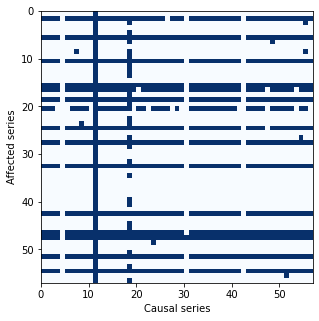

In [5]:
GC_est = clstm.GC().cpu().data.numpy()
fig, axarr = plt.subplots( figsize=(10, 5))
axarr.imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr.set_ylabel('Affected series')
axarr.set_xlabel('Causal series')
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('less loss = ',min(train_loss_adam).cpu().numpy())

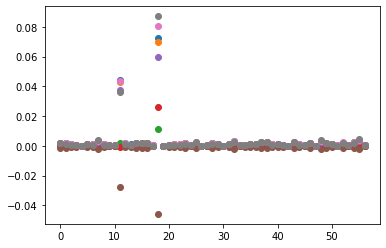

In [7]:
clstm.weight_causality(1)